In [570]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn.linear_model import LinearRegression
from geopy import distance,Nominatim

In [571]:
def date_parser(date):
    formato = "%d-%m-%Y/%H:%M"
    return pd.to_datetime(date, format=formato)

df = pd.read_csv('tabelaTotal.csv',parse_dates=['dataTimeUpload'],index_col=['dataTimeUpload'],date_parser=date_parser)

In [572]:
df['nome'] = df['nome'].apply(lambda x: 1 if isinstance(x,str) else 0)
df = pd.concat([df,pd.get_dummies(df['sexo'],dtype=float)],axis=1)
df = pd.concat([df,pd.get_dummies(df['idUsuario'],dtype=float)],axis=1).drop('idUsuario',axis=1)

In [573]:
df['distancia'] = df['distancia'].apply(lambda x:'Belém' if x == 'Belem' else x)
df['distancia'] = df['distancia'].apply(lambda x:'Maranhão' if x == 'maranhao' else x)

In [574]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="myGeocoder")

coords = (geolocator.geocode('R. da Basílica - Nazaré, Belém - PA').latitude, geolocator.geocode('R. da Basílica - Nazaré, Belém - PA').longitude)

In [575]:
df['Coordenadas_CasaPlacido'] = df['atendimento'].apply(lambda x: coords)

In [576]:
def retornar_lat_long(x):
    location = geolocator.geocode(x)
    return (location.latitude,location.longitude)

array_temporario = df['distancia'].drop_duplicates().apply(retornar_lat_long)

df['cidades'] = df['distancia'].copy()

for index in range(len(array_temporario)):   
    df['distancia'] = df['distancia'].apply(lambda x: array_temporario[index] if x == df['distancia'].drop_duplicates()[index] else x)
    coordenadas_cidades[array_temporario[index]] = df['cidades'].iloc[0]

In [577]:
df['distancia'] = df['distancia'].apply(lambda x: (distance.distance(df['Coordenadas_CasaPlacido'][0], x).km))

In [578]:
df_temp = df.drop(['Coordenadas_CasaPlacido','nomeUsuario','atendimento','cidades','sexo'],axis=1).resample('d').sum()
#df_temp.columns

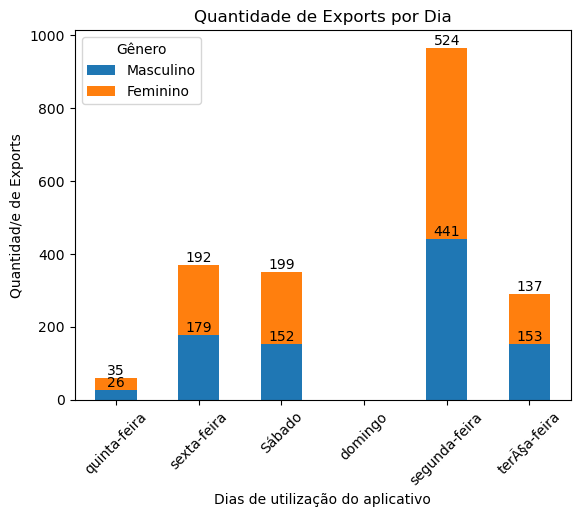

In [579]:
import locale
import matplotlib.pyplot as plt
import pandas as pd

# Configurar o idioma para Português
locale.setlocale(locale.LC_TIME, 'pt_BR.UTF-8')

df_temp['dia_da_semana'] = df_temp.index.strftime('%A')
df_temp['dia_da_semana'] = df_temp['dia_da_semana'].apply(lambda x: 'Sábado' if x == 'sÃ¡bado' else x)

# Seus dados
data = {
    'Total': df_temp['nome'],
    'Masculino': df_temp['Masculino'],
    'Feminino': df_temp['Feminino'],
}

df_temp2 = pd.DataFrame(data)

# Cores das barras
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Criar o gráfico de barras empilhadas
ax = df_temp2.plot(x='Total', kind='bar', stacked=True, color=colors)

# Configurações adicionais do gráfico
plt.xlabel('Dias de utilização do aplicativo')
plt.ylabel('Quantidad/e de Exports')
plt.title('Quantidade de Exports por Dia')

# Defina os rótulos do eixo x manualmente
plt.xticks(range(len(df_temp['dia_da_semana'])), df_temp['dia_da_semana'])

# Adicionar rótulos às barras
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:  # Evita rótulos em barras vazias
        ax.annotate(f'{height:.0f}', (x + width / 2, y + height), ha='center', va='bottom')

# Rotacionar os rótulos do eixo x para melhor visualização
plt.xticks(rotation=45)


# Mostrar o gráfico
plt.legend(title='Gênero')
plt.show()

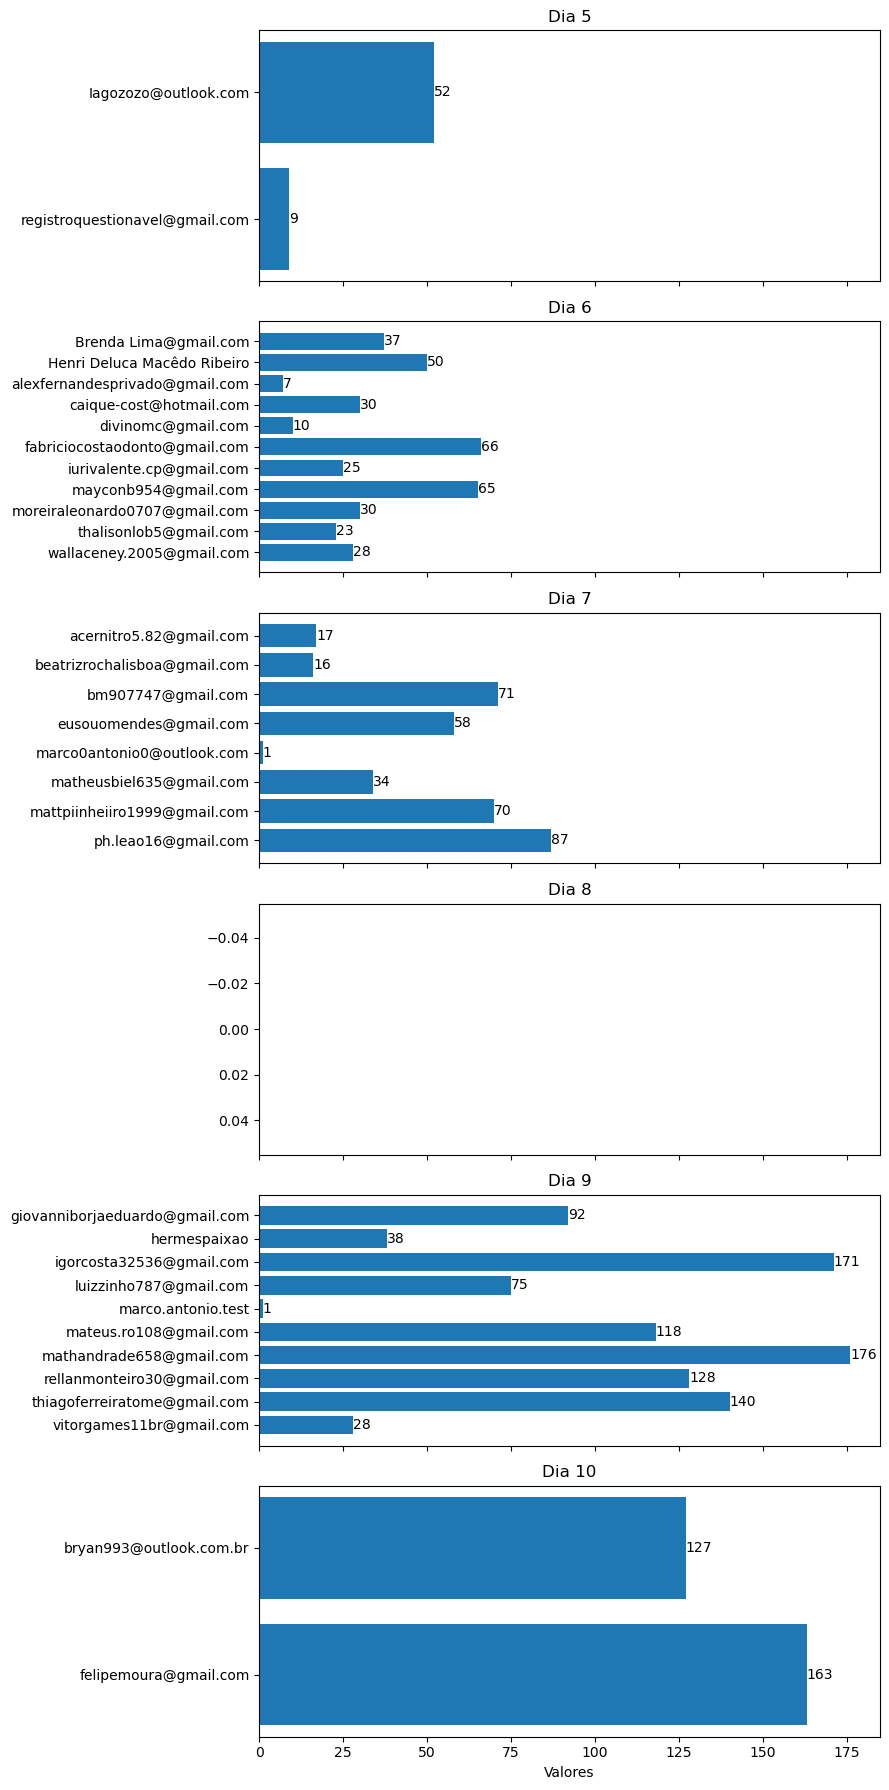

In [580]:
import pandas as pd
import matplotlib.pyplot as plt

# Suponha que 'df_temp' seja o seu DataFrame
data_alvo = '2023-10-05'
coluna_alvo = 'Brenda Lima@gmail.com'

# Obtenha os dias únicos no índice
dias_unicos = df_temp.index.day.unique()

# Crie uma figura com subplots para cada dia
fig, axs = plt.subplots(len(dias_unicos), 1, figsize=(9, 3*len(dias_unicos)), sharex=True)

for i, day in enumerate(dias_unicos):
    intervalo_datas = df_temp.loc[f'2023-10-{day}':f'2023-10-{day}', coluna_alvo:].drop('dia_da_semana',axis=1)
    colunas_sem_zero = intervalo_datas.loc[:, ~(intervalo_datas == 0).all()]

    values = colunas_sem_zero.values[0]
    columns = colunas_sem_zero.columns
    
    axs[i].barh(y=columns, width=values)
    axs[i].set_title(f'Dia {day}')
    axs[i].invert_yaxis()
    
    for j, value in enumerate(values):
        axs[i].text(value, j, f'{int(value)}', va='center', fontsize=10)

plt.xlabel('Valores')
plt.tight_layout()
plt.show()


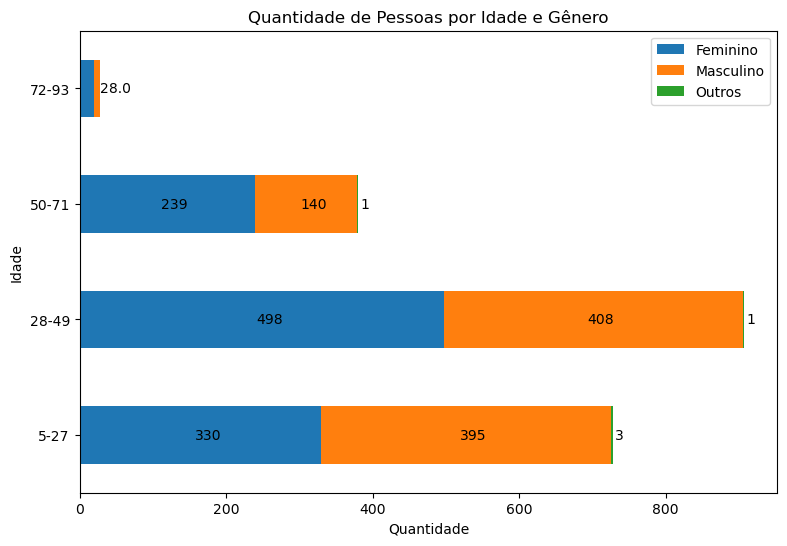

In [581]:
df['idade'] = pd.cut(df['idade'],4)
# Crie um gráfico de barras empilhado
ticks = ['5-27','28-49','50-71','72-93']

grouped = df[['Feminino', 'Masculino','Outros']].groupby(df['idade']).sum()
cumulative_x = [0] * len(grouped)

sum_value = grouped.min().nsmallest(3).values

ax = grouped.plot(kind='barh', stacked=True,figsize=(9, 6))
ax.set_yticklabels(ticks)
ax.set_xlabel("Quantidade")
ax.set_ylabel("Idade")
ax.set_title("Quantidade de Pessoas por Idade e Gênero")

count = 0

# Adicione os valores nas barras
for i, row in enumerate(grouped.iterrows()):
    for j, val in enumerate(row[1]):
        middle_x = cumulative_x[i] + val / 2  # Posição média da barra empilhada
        cumulative_x[i] += val  # Atualizar a posição cumulativa
        if (int(val) in sum_value) and (count < 1):
            ax.text(val+(val*.4), i, str(sum_value.sum()), ha='left', va='center', fontsize=10)
            count += 1
        elif (int(val) in sum_value):
            continue
        else:
            ax.text(middle_x+10, i, str(int(val)), ha='center', va='center', fontsize=10)

plt.show()

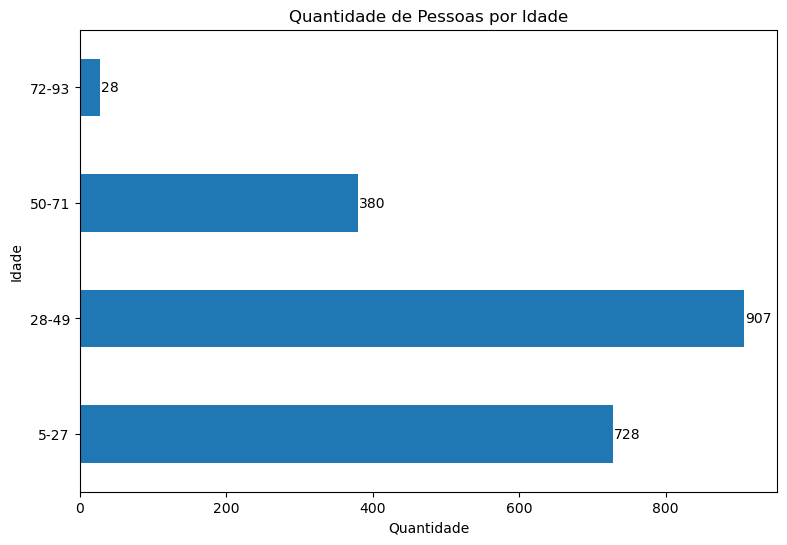

In [582]:
#df['idade'] = pd.cut(df['idade'],4)
ticks = ['5-27','28-49','50-71','72-93']

plt.figure(figsize=(9, 6))

# Crie o gráfico de barras horizontal
ax = df['idade'].value_counts().sort_index().plot(kind='barh')
ax.set_yticklabels(ticks)
ax.set_xlabel("Quantidade")
ax.set_ylabel("Idade")
ax.set_title("Quantidade de Pessoas por Idade")

# Adicione os valores nas barras
for i, v in enumerate(df['idade'].value_counts().sort_index()):
    ax.text(v + 1, i, str(v), va='center', fontsize=10)

plt.show()

In [585]:
df = pd.concat([df,pd.get_dummies(df['cidades'],dtype=float)],axis=1).drop('cidades',axis=1)
df_temp = df.drop(['Coordenadas_CasaPlacido','nomeUsuario','atendimento'],axis=1).groupby('idade').resample('d').sum()

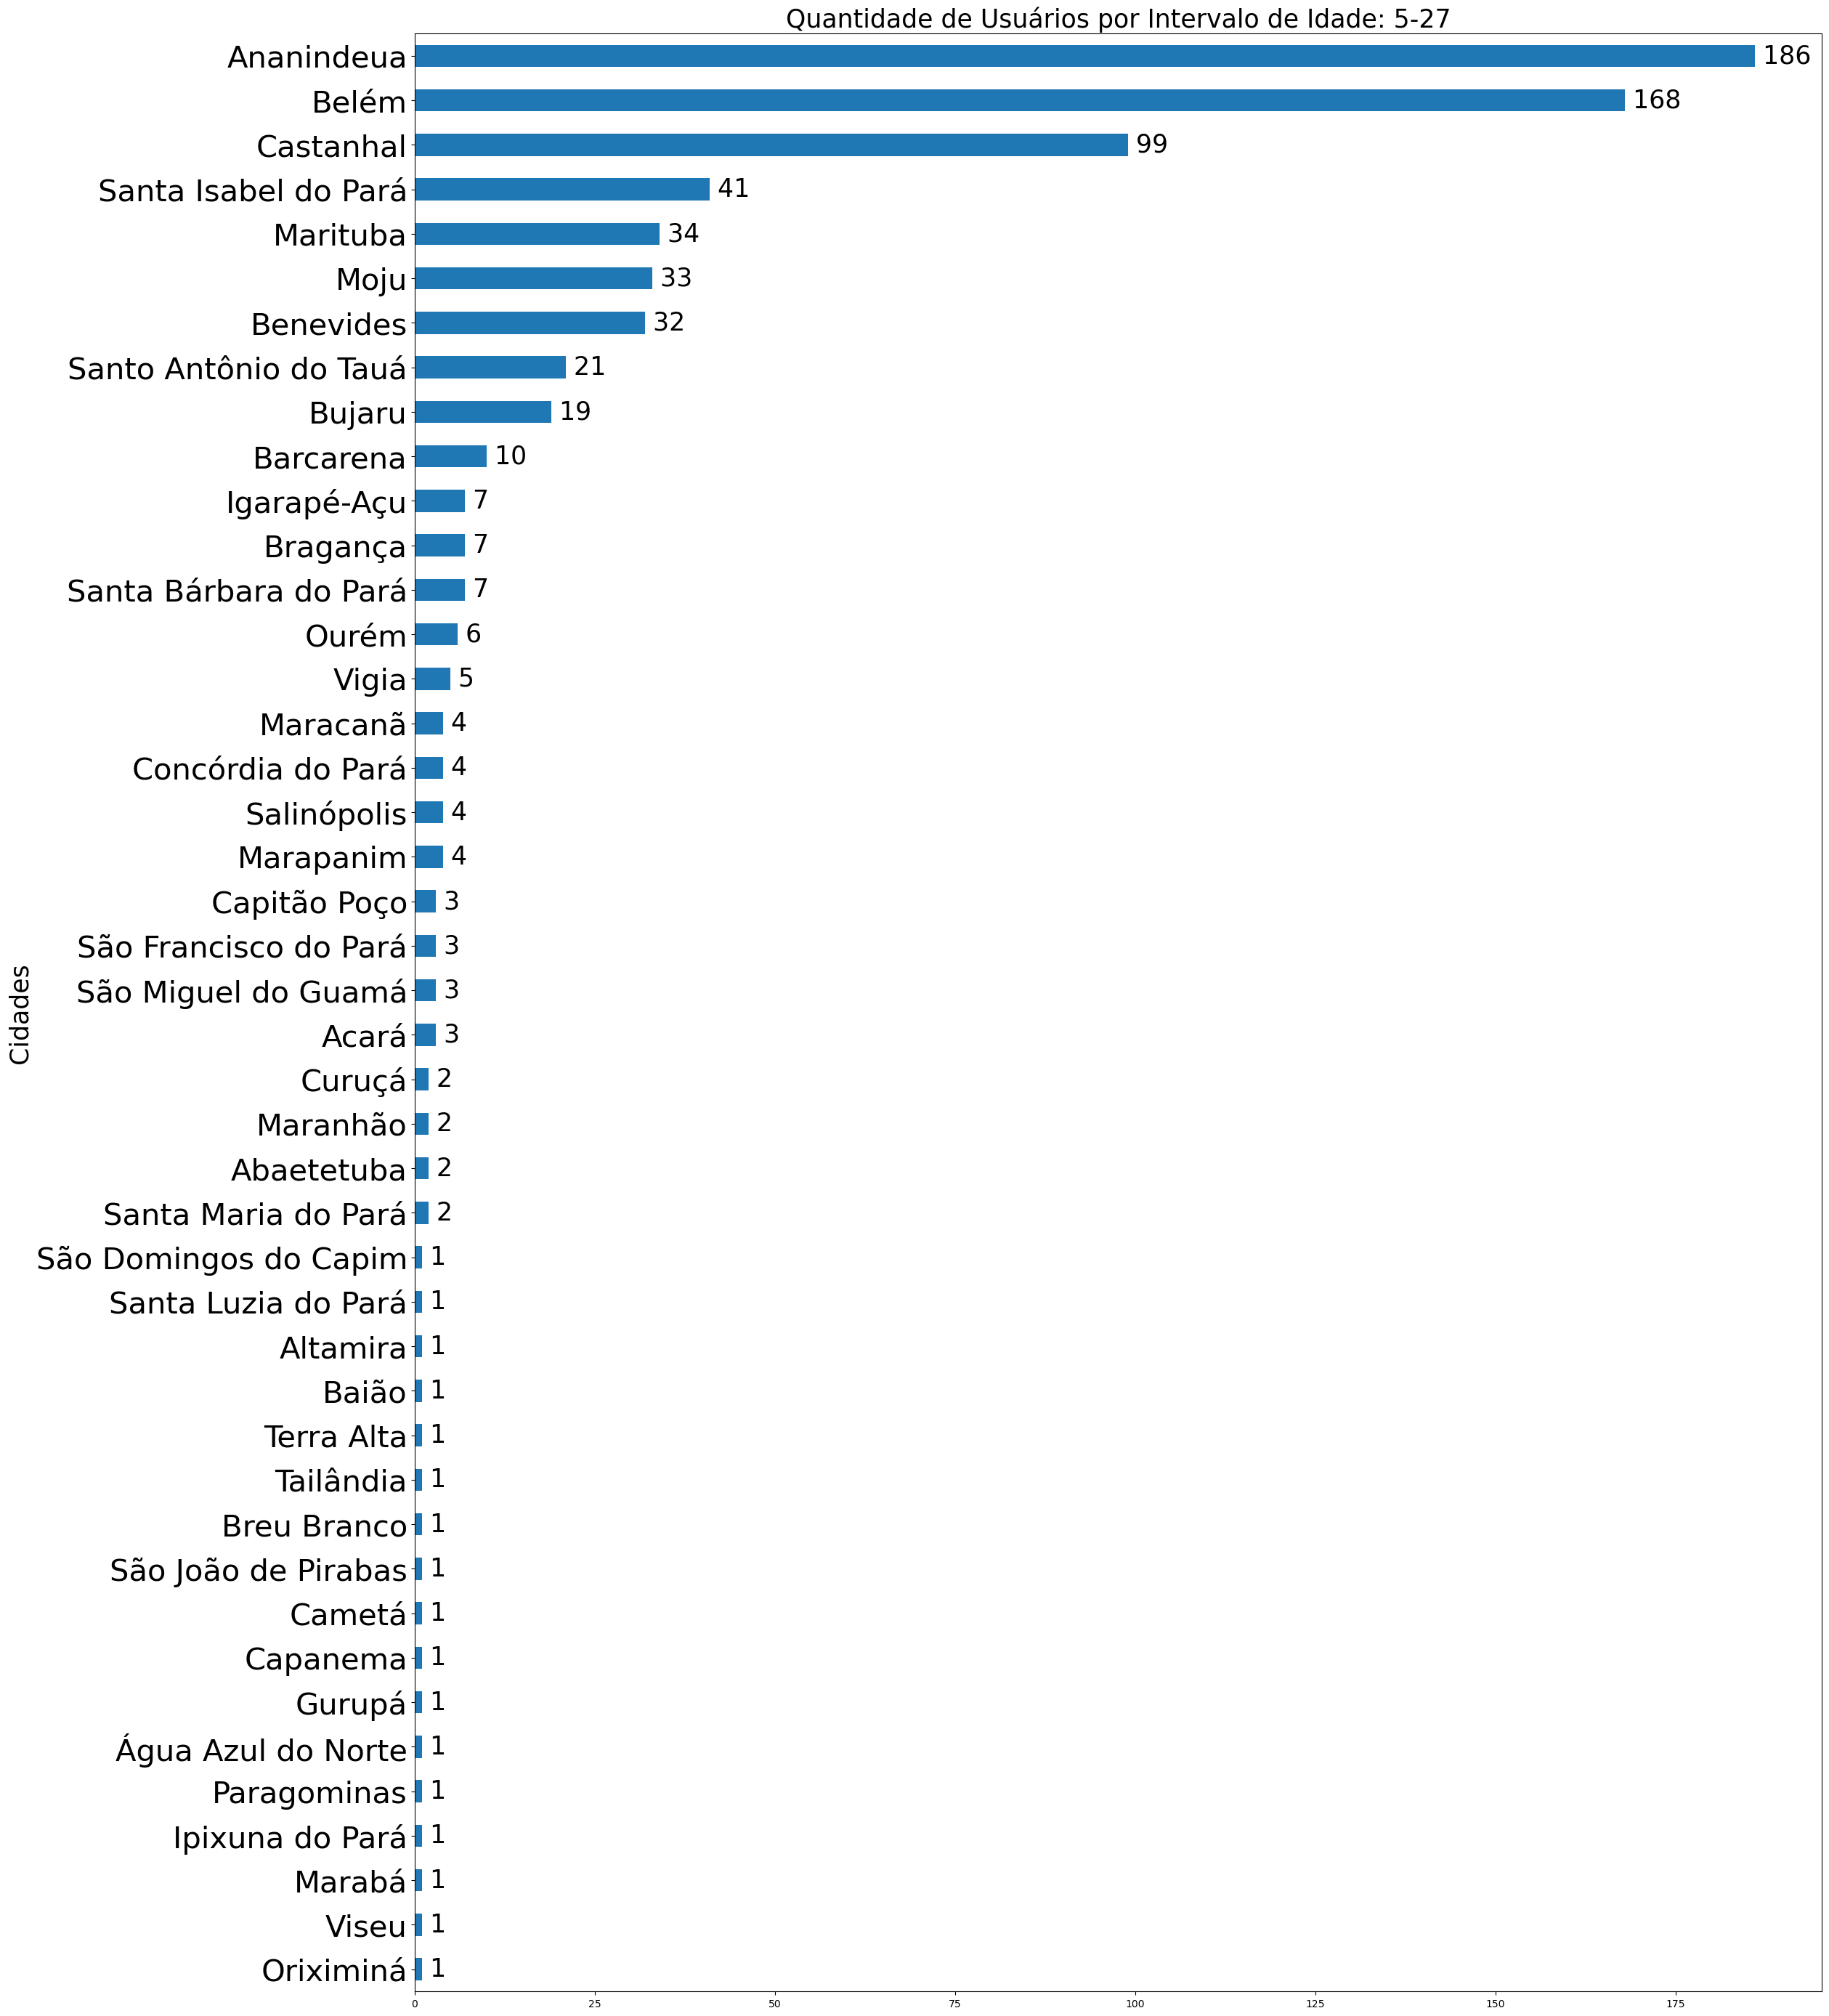

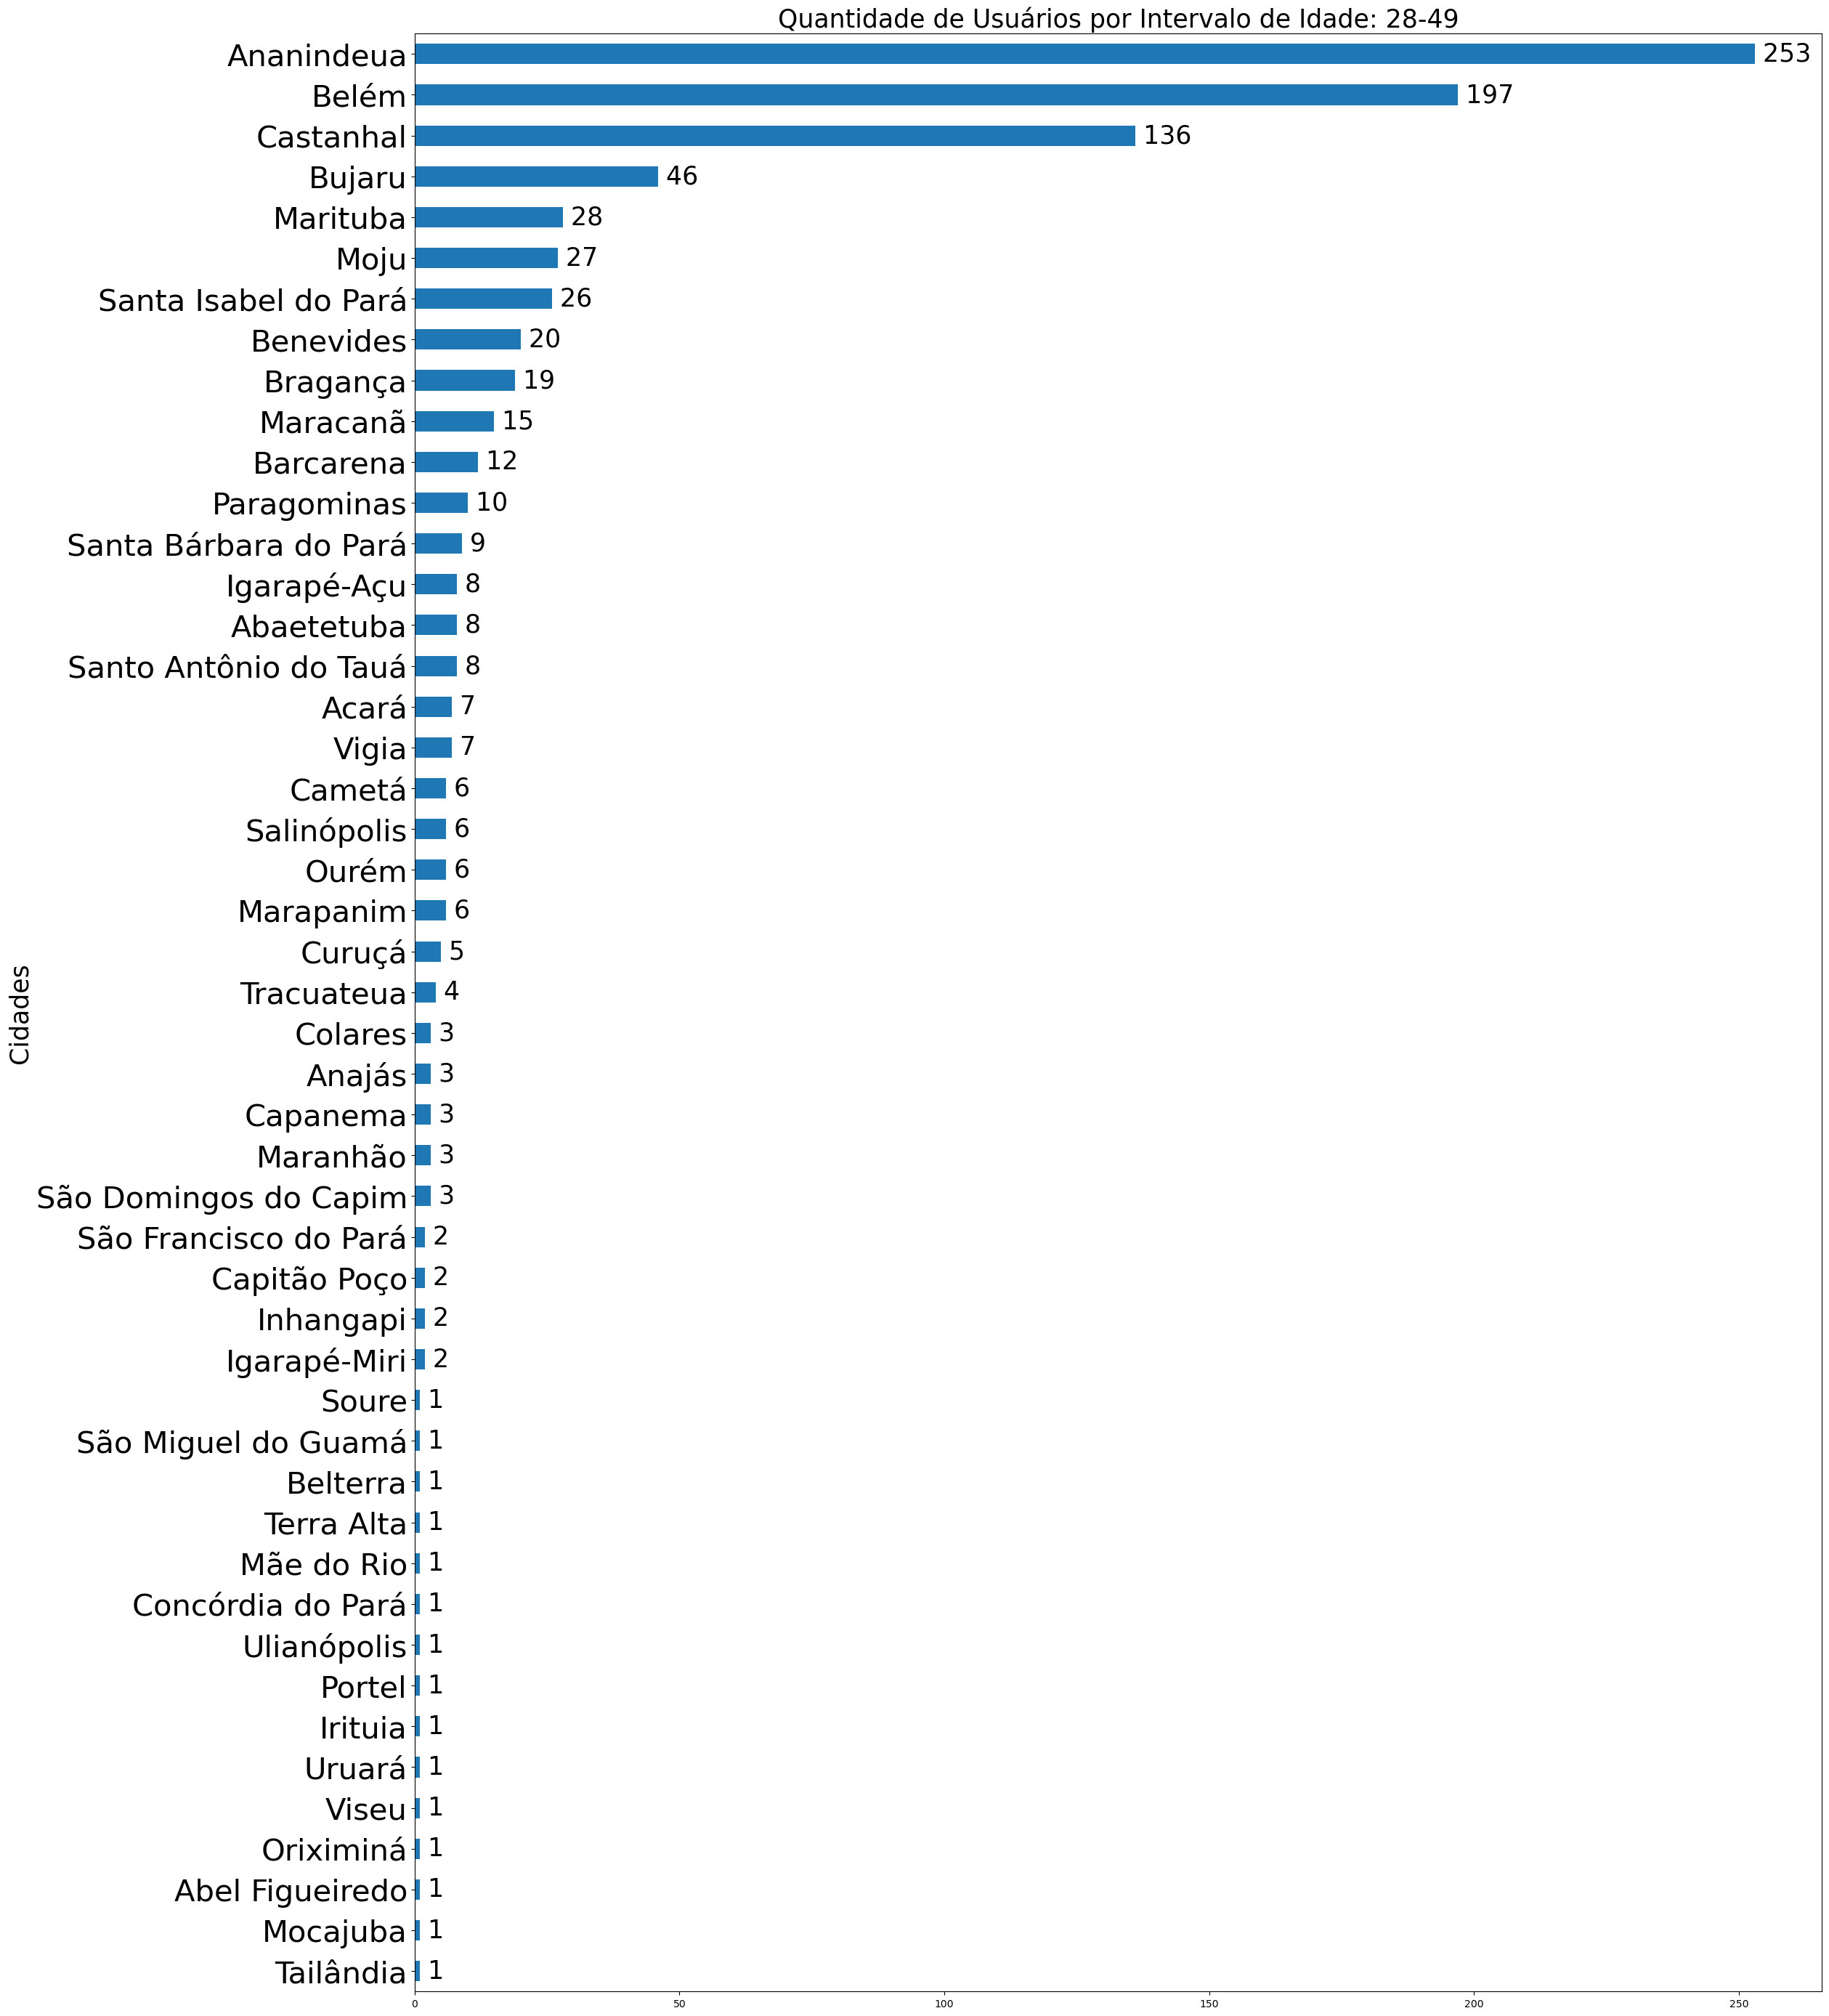

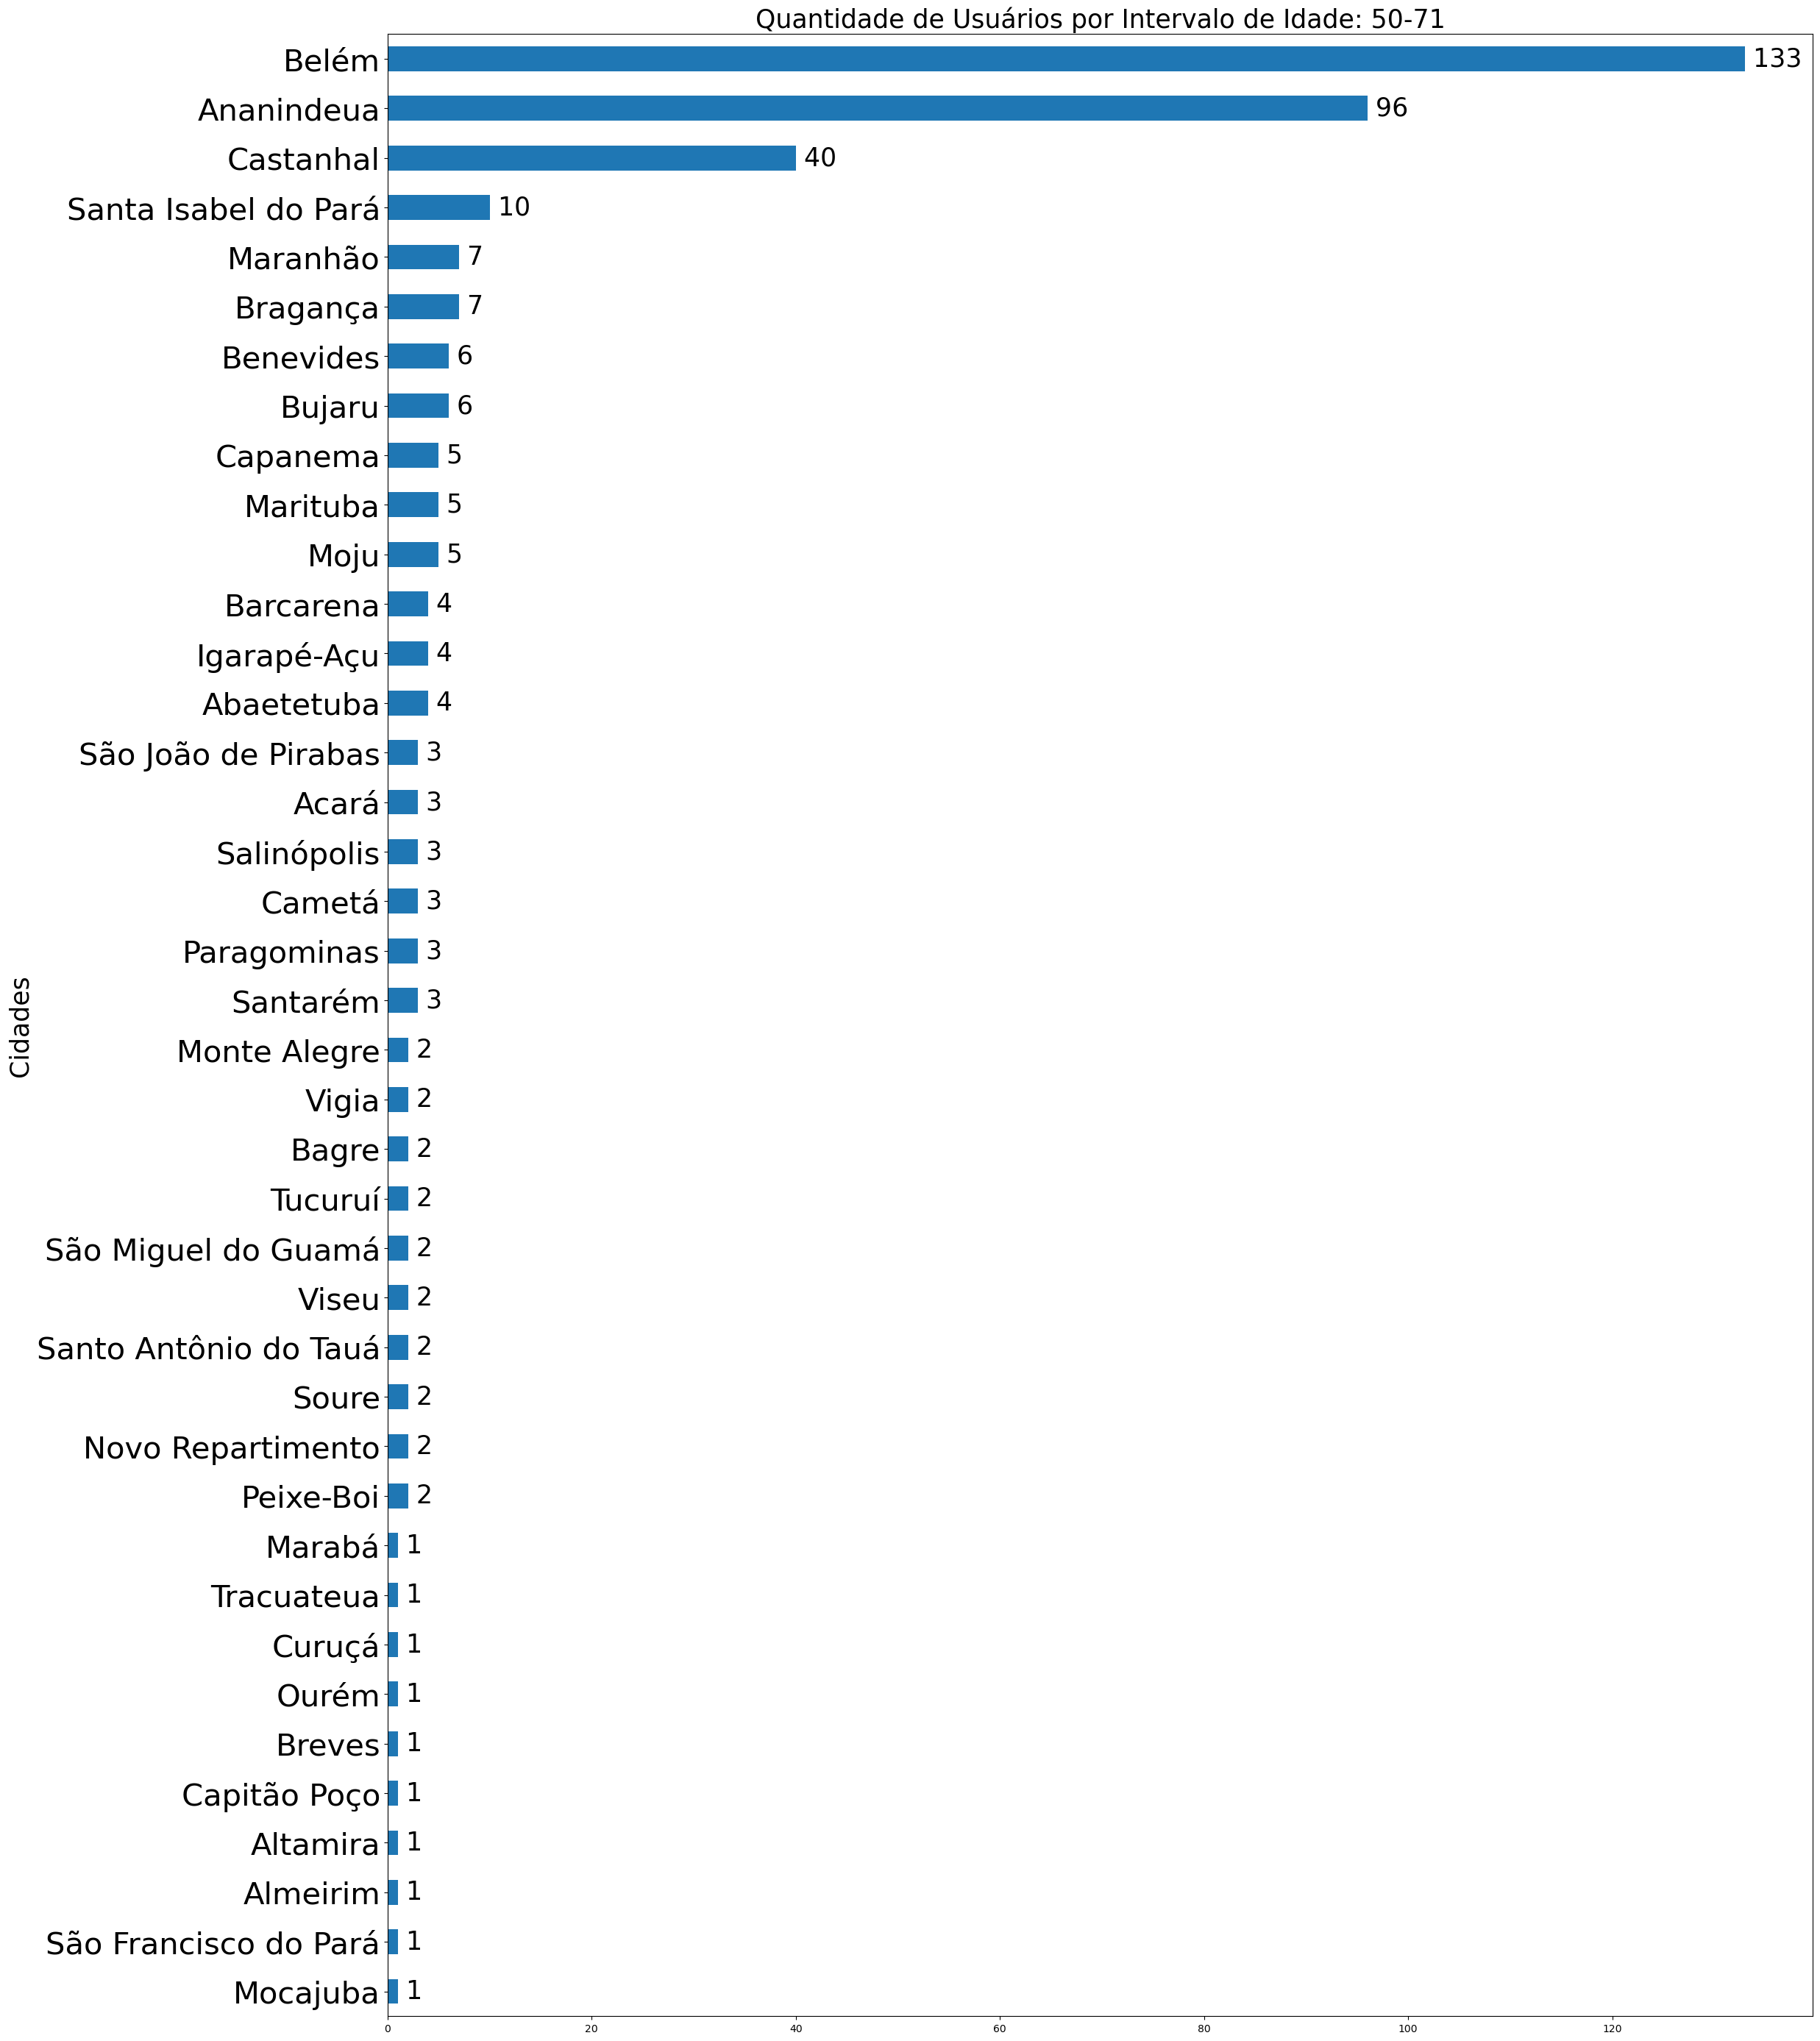

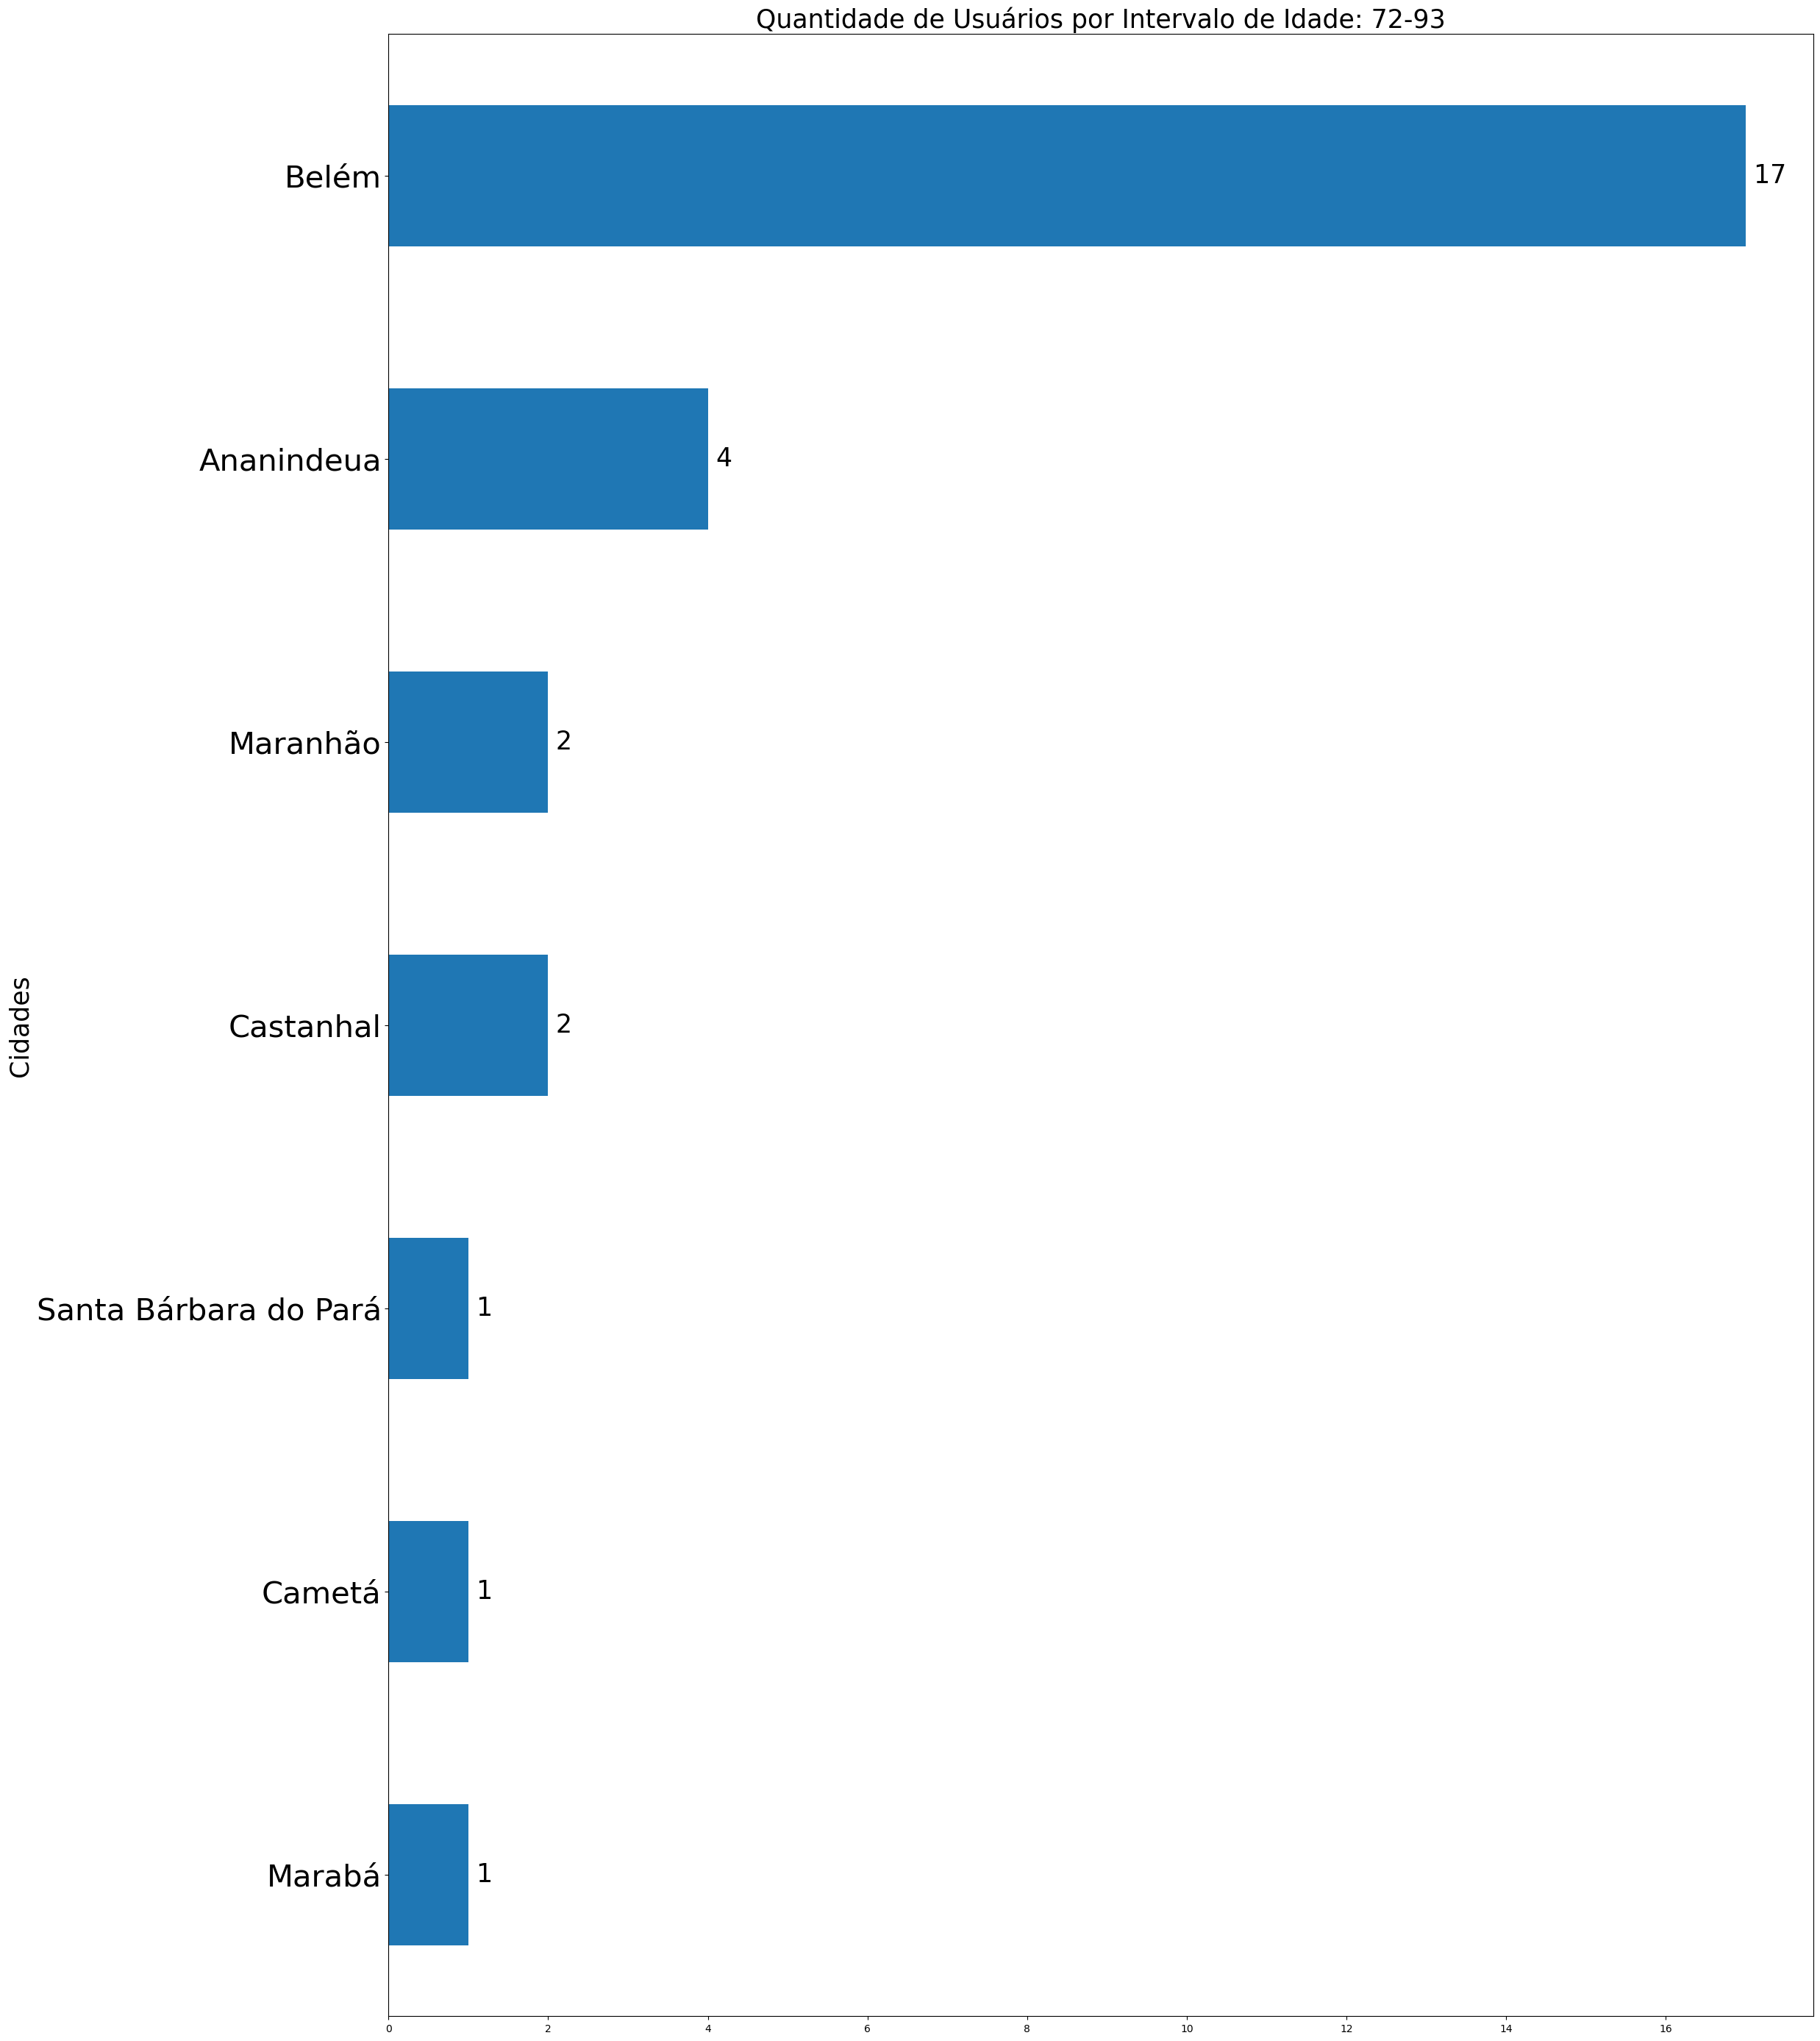

In [588]:
ticks = ['5-27', '28-49', '50-71', '72-93']

range_var = df_temp.shape[0]
divisor = range_var // 4

for i in range(0, range_var, divisor):
    new_df = df_temp.loc[df_temp.index[i][0]:df_temp.index[i][0], 'Abaetetuba':].sum().sort_values(ascending=True)
    new_df = new_df[new_df != 0]
    ax = new_df.plot(kind='barh', stacked=True, figsize=(25, 35))
    plt.title(f'Quantidade de Usuários por Intervalo de Idade: {ticks[int(i/divisor)]}',fontsize=25)
    plt.ylabel(f'Cidades',fontsize=25)
    plt.yticks(fontsize=30) 

    for j, value in enumerate(new_df):
        ax.text(value, j, f' {int(value)}', ha='left', va='center',fontsize=25)
    plt.show()
    print('\n\n\n')

In [589]:
df = pd.read_csv('tabelaTotal.csv') #Reiniciando o dataframe pra aplicar novos comportamentos
df = df.drop(['id', 'idUsuario', 'nomeUsuario', 'nome', 'atendimento', 'dataTimeUpload'], axis=1)
df['idade'] = pd.cut(df['idade'], 4)
df.index = df['idade']

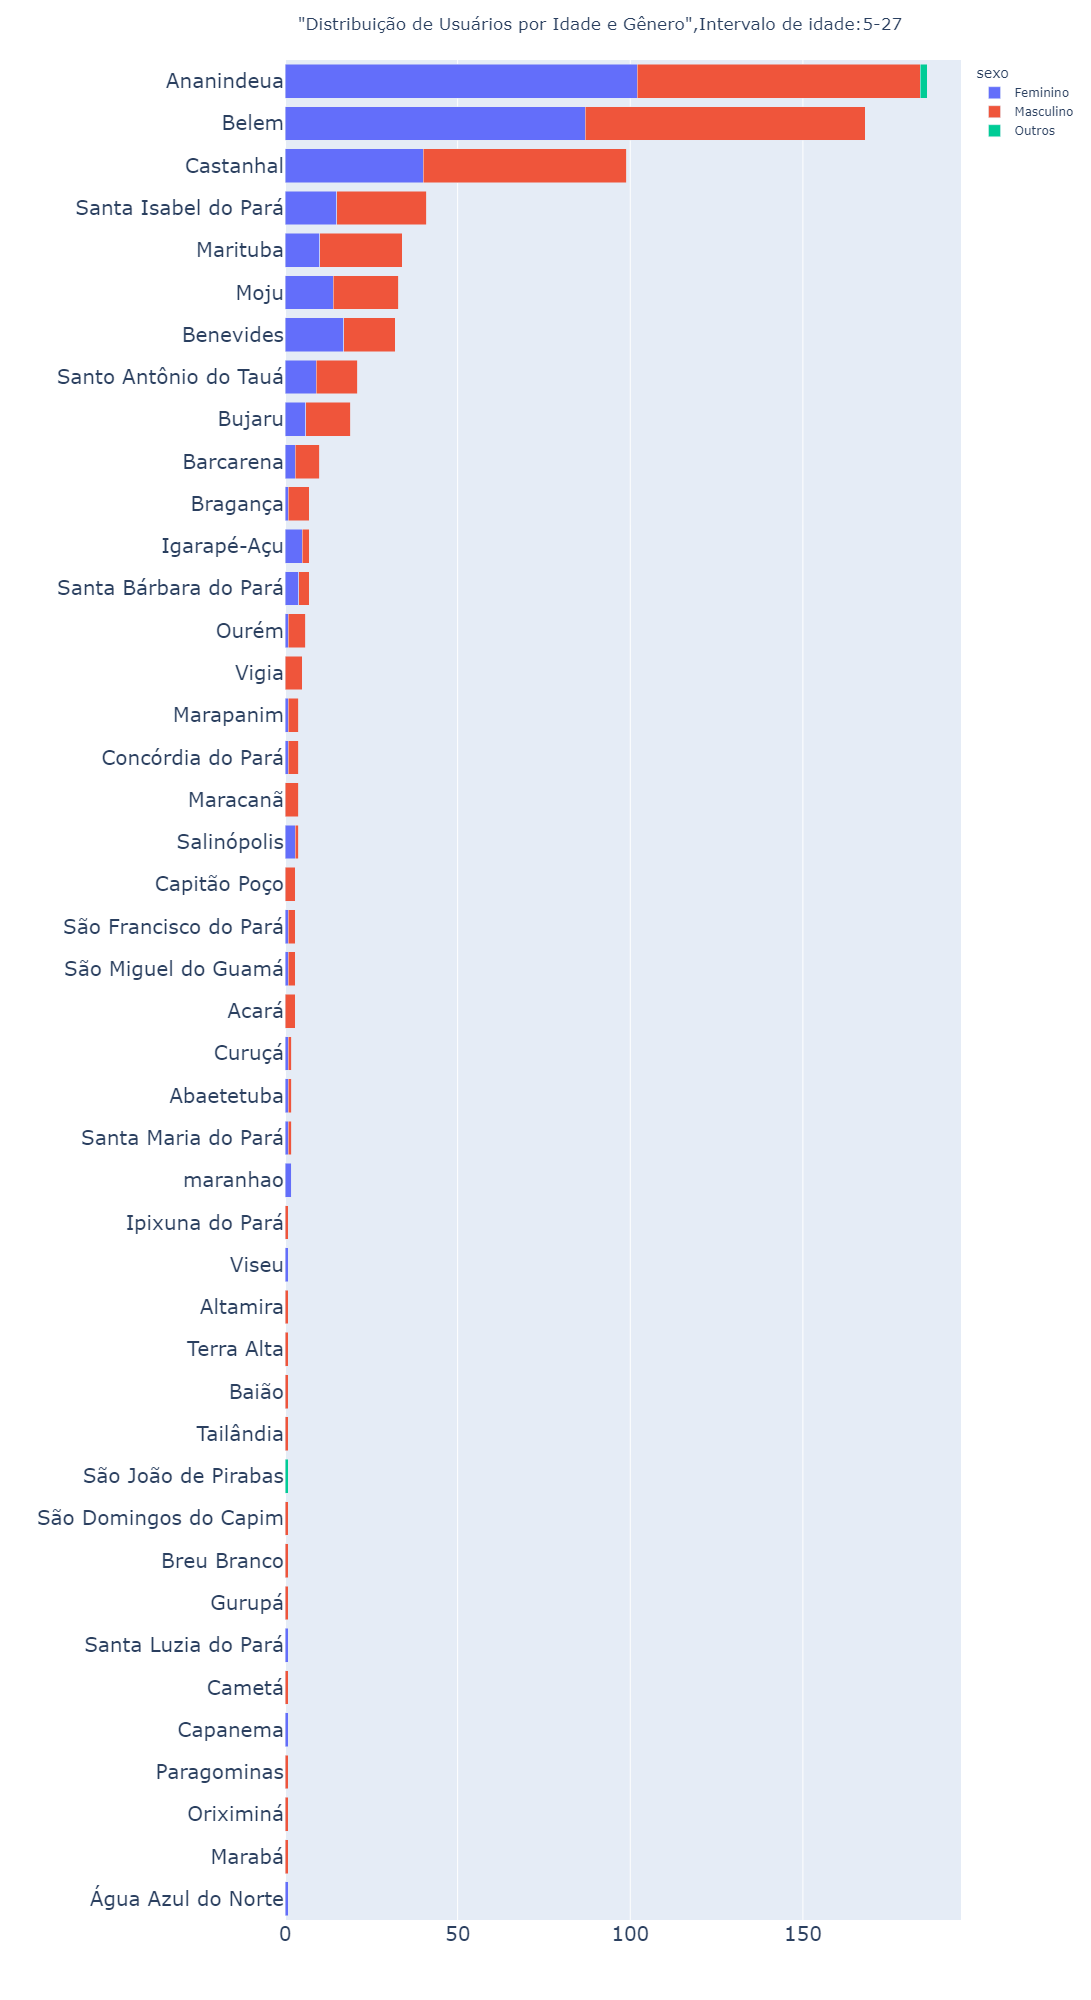

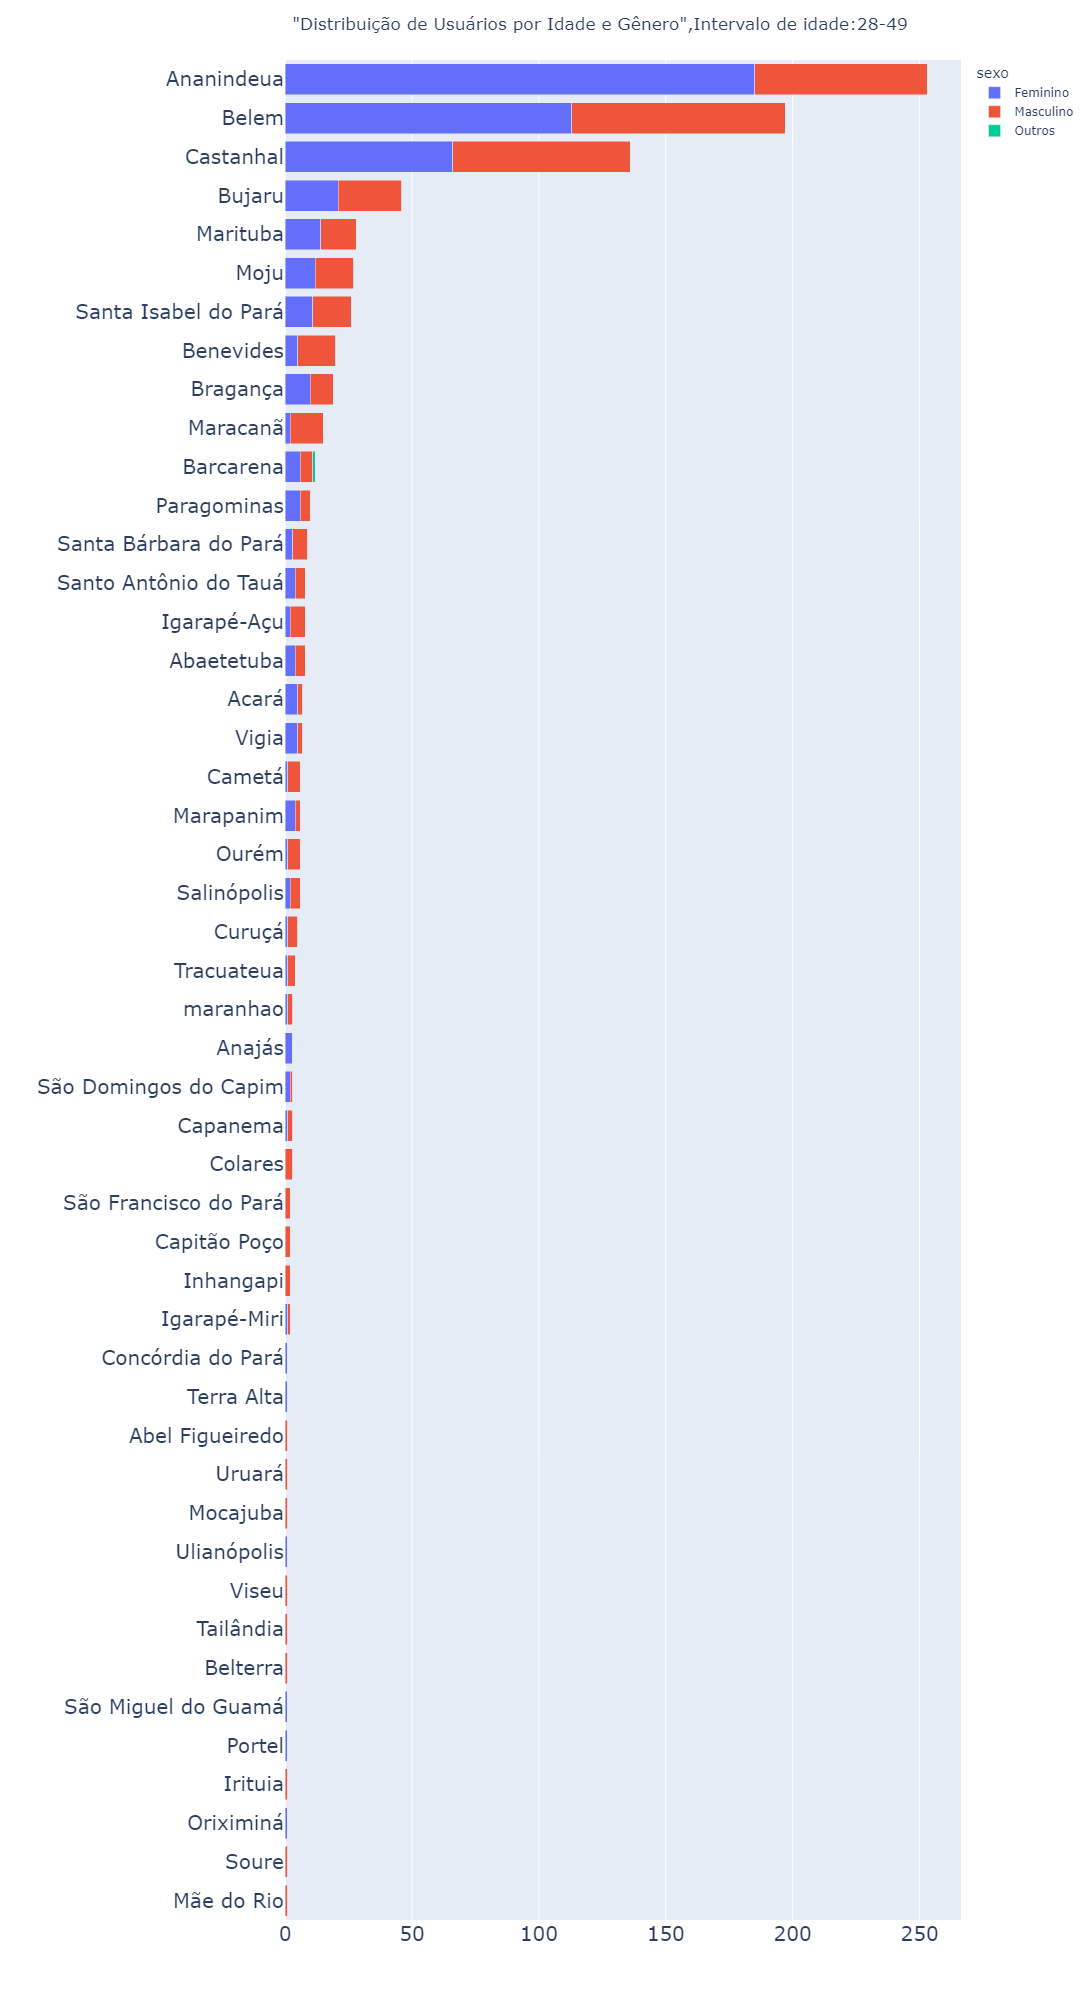

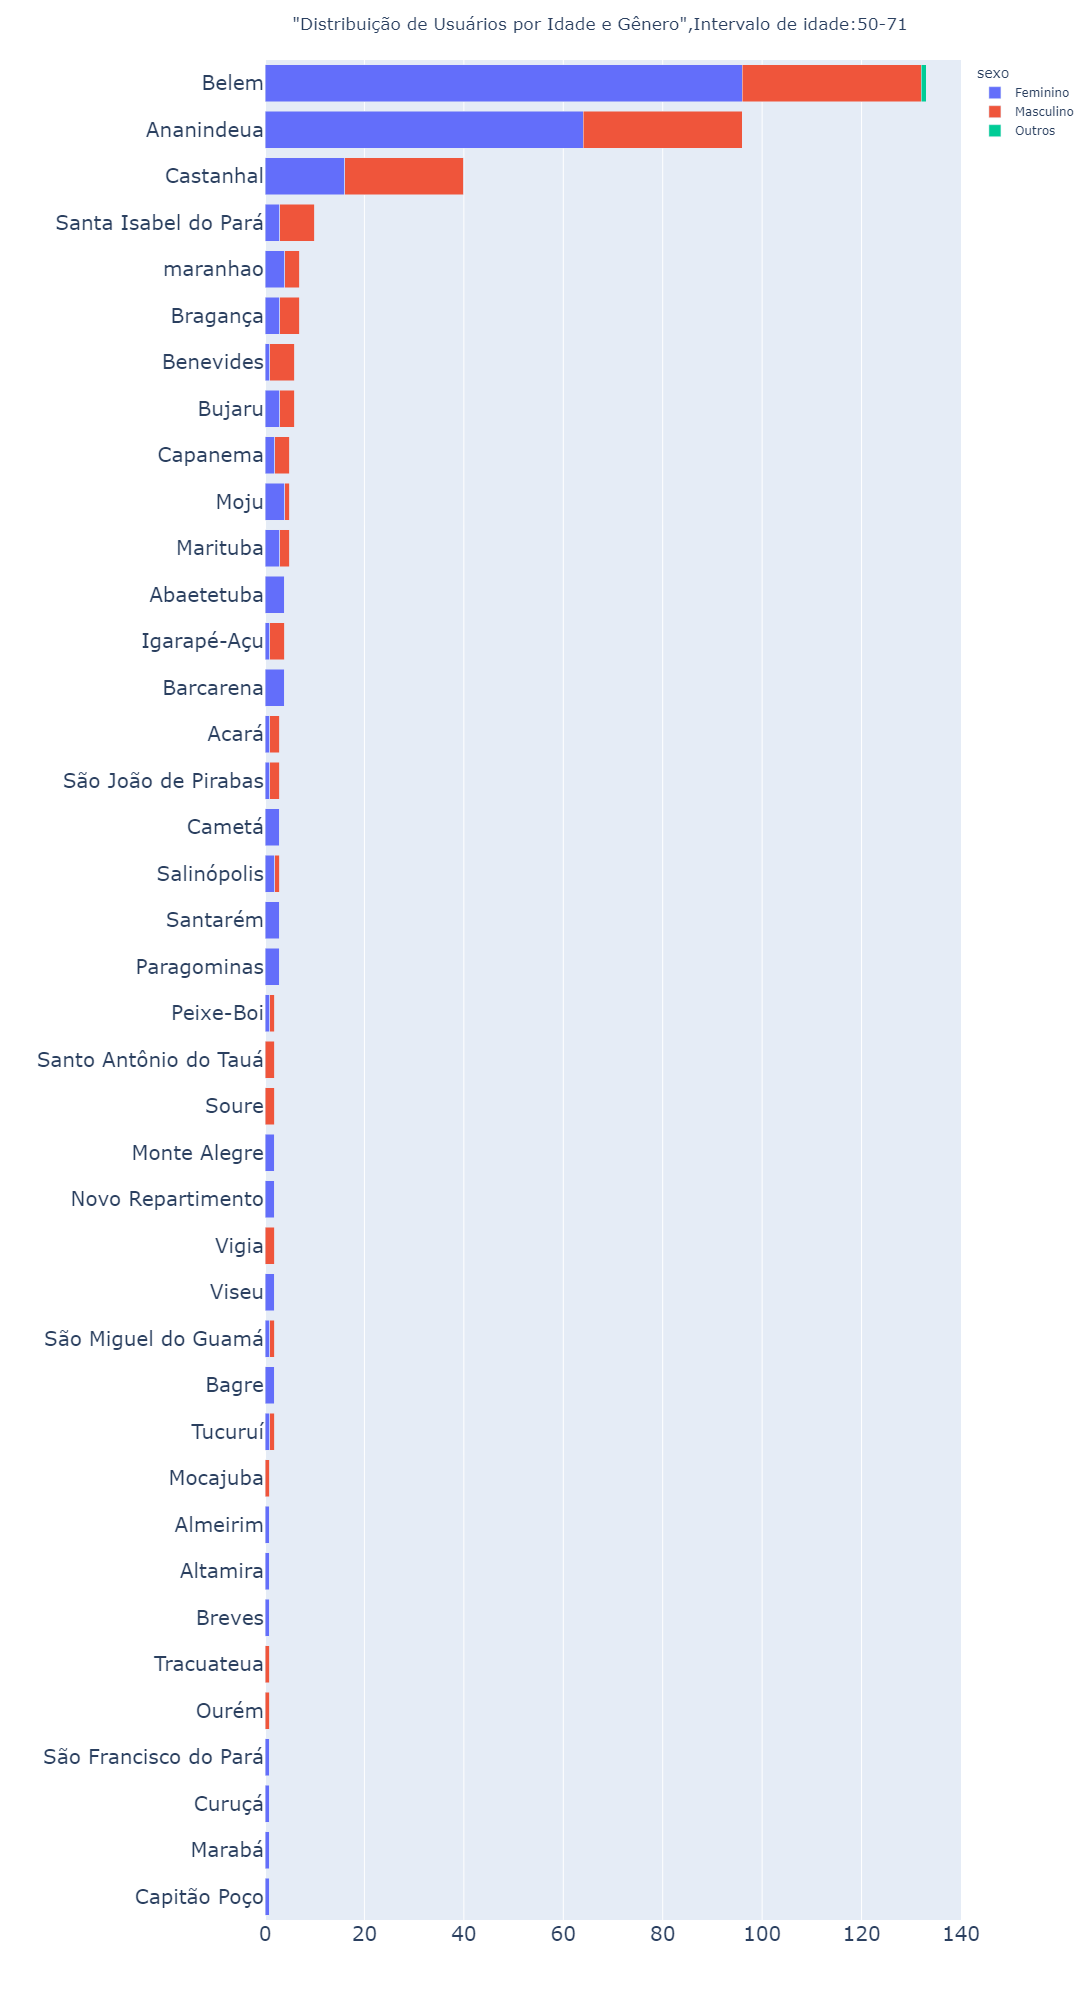

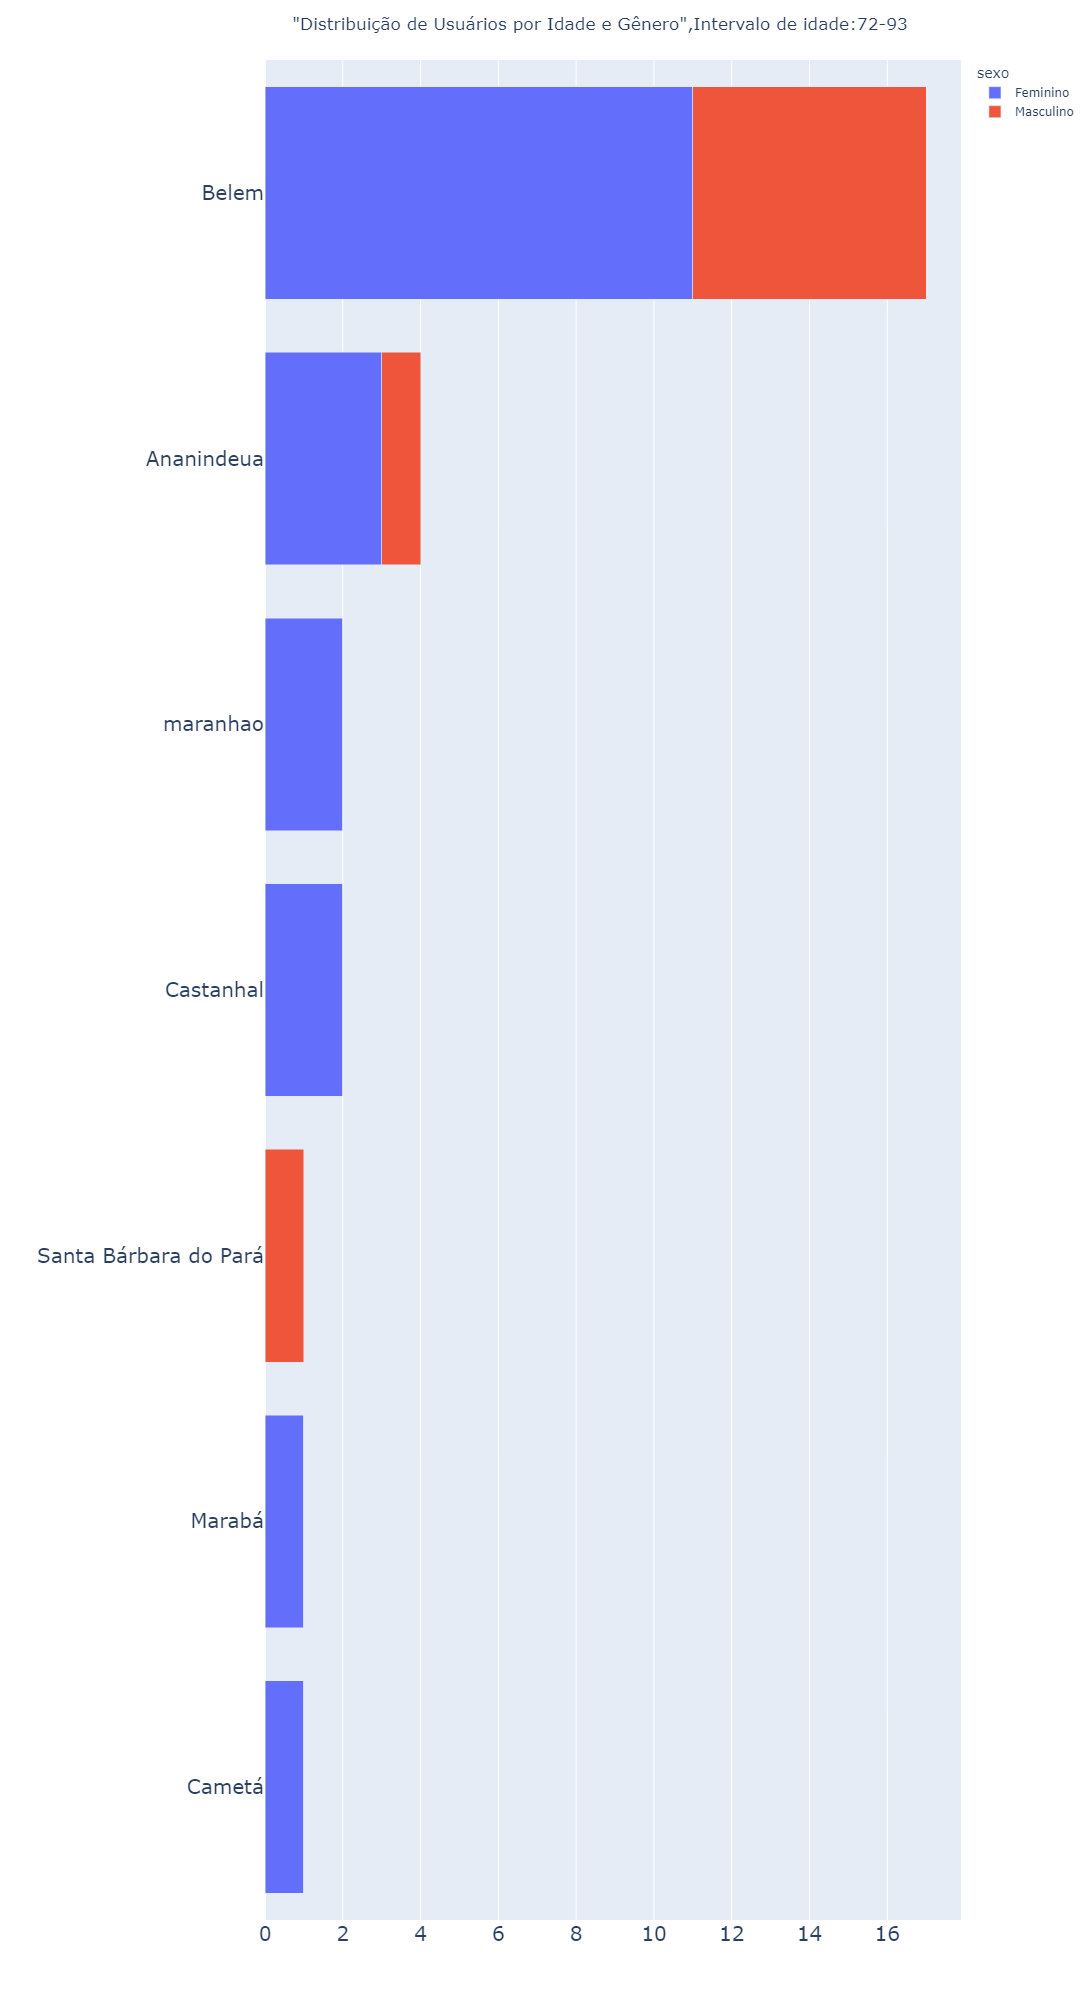

In [590]:
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
from math import ceil


init_notebook_mode(connected=True)

ticks = ['5-27', '28-49', '50-71', '72-93']

range_var =  pd.pivot_table(data=df, index=['distancia'], columns='sexo', values='sexo', aggfunc='count', fill_value=0).shape[0]

divisor = range_var // 3

for i in range(0, range_var+1, divisor):

    new_df = pd.pivot_table(data=df.loc[df.index.unique().sort_values()[ceil(i/divisor)]], index=['distancia'], columns='sexo', values='sexo', aggfunc='count', fill_value=0)

    new_df['Total'] = new_df.sum(axis=1)
    new_df = new_df.sort_values(by='Total', ascending=True)
    new_df = new_df.drop(columns='Total')

    fig = px.bar(new_df, y=new_df.index, x=new_df.columns, barmode='stack')
    fig.update_layout(title=f'"Distribuição de Usuários por Idade e Gênero",Intervalo de idade:{ticks[int(i/divisor)]}', xaxis_title='',title_x=0.55, yaxis_title='',width=1400, height=2000)
    fig.update_xaxes(tickfont=dict(size=20))
    fig.update_yaxes(tickfont=dict(size=20))


    iplot(fig)
    print('\n\n\n')
